# Training NN for the final Decision Making

## Load Tensorflow and check GPU availability

In [1]:
from tensorflow import keras
from tensorflow.keras.datasets import mnist
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import RMSprop
from tensorflow.python.client import device_lib

for device in device_lib.list_local_devices():
    print(device.physical_device_desc)

2024-06-05 15:26:32.812139: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-06-05 15:26:32.812159: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-06-05 15:26:32.812928: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2024-06-05 15:26:32.817219: I tensorflow/core/platform/cpu_feature_guard.cc:182] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-06-05 15:26:33.430801: W tensorflow/compiler/tf2


device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.9


2024-06-05 15:26:34.254064: I tensorflow/core/common_runtime/gpu/gpu_device.cc:2327] Ignoring visible gpu device (device: 1, name: NVIDIA GeForce GTX 1050 Ti, pci bus id: 0000:01:00.0, compute capability: 6.1) with core count: 6. The minimum required count is 8. You can adjust this requirement with the env var TF_MIN_GPU_MULTIPROCESSOR_COUNT.
2024-06-05 15:26:34.258771: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1929] Created device /device:GPU:0 with 1165 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 4060 Ti, pci bus id: 0000:07:00.0, compute capability: 8.9


# Load input datasets

In [2]:
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from pyarrow import Table

df = pd.read_parquet('data/preliminary_results.parquet')

# IMPORTANT: set labels:
df.loc[df['label'].str.startswith(('phishing', 'malware', 'misp', 'dga')), 'label'] = 'malign'
df.loc[df['label'] != 'malign', 'label'] = 'benign'

class_map = {"benign": 0, "malign": 1}

# Handle NaNs
df.fillna(-1, inplace=True)


# SUBSAMPLE (OPTIONAL)
subsample = 1.0 # 1.0 means no subsample
if subsample < 1.0:
    df = df.sample(frac=subsample)

# Drop the domain name column
df.drop("domain_name", axis=1, inplace=True)

labels = df['label'].apply(lambda x: class_map[x]) # y vector
features = df.drop('label', axis=1).copy() # X matrix

print(f"Total samples: {len(df)}")

df

Total samples: 120000


,dns_available,dns_nonzero,tls_available,tls_nonzero,ip_available,ip_nonzero,rdap_available,rdap_nonzero,geo_available,geo_nonzero,...,dga_binary_nn_result,phishing_sum,phishing_avg,phishing_prod,malware_sum,malware_avg,malware_prod,total_sum,total_avg,total_prod
0,0.600,0.200,1.000000,0.416667,1.000,0.625,0.833333,0.291667,1.0,0.722222,...,8.610196e-10,9.140458e-06,4.570229e-06,0.000000,5.837178e-07,2.918589e-07,0.000000,0.000010,1.945007e-06,0.000000e+00
1,0.475,0.000,0.041667,0.000000,0.625,0.000,0.833333,0.000000,1.0,0.000000,...,9.984829e-01,1.029436e+00,5.147178e-01,0.029436,1.964059e+00,9.820293e-01,0.964059,3.991977,7.983954e-01,2.833462e-02
2,0.950,0.625,1.000000,0.458333,1.000,0.750,1.000000,0.708333,1.0,1.000000,...,4.695278e-03,9.990606e-01,4.995303e-01,0.000000,9.996044e-01,4.998022e-01,0.000000,2.003360,4.006721e-01,0.000000e+00
3,0.900,0.525,1.000000,0.416667,1.000,0.750,1.000000,0.708333,1.0,0.722222,...,1.285542e-19,1.329724e-01,6.648622e-02,0.000000,6.383437e-04,3.191718e-04,0.000000,0.133611,2.672216e-02,0.000000e+00
4,0.900,0.525,1.000000,0.458333,1.000,0.625,1.000000,0.625000,1.0,0.666667,...,8.292444e-23,1.402564e+00,7.012821e-01,0.402564,1.999984e+00,9.999922e-01,0.999984,3.402549,6.805097e-01,3.338190e-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,0.900,0.375,0.041667,0.000000,0.625,0.125,0.833333,0.000000,1.0,0.000000,...,2.692529e-33,9.551791e-07,4.775896e-07,0.000000,7.565303e-07,3.782652e-07,0.000000,0.000002,3.423419e-07,0.000000e+00
119996,0.600,0.200,1.000000,0.833333,1.000,0.250,1.000000,0.708333,1.0,0.666667,...,5.136497e-12,5.561209e-05,2.780604e-05,0.000000,1.329856e-05,6.649281e-06,0.000000,0.000069,1.378213e-05,0.000000e+00
119997,0.900,0.525,1.000000,0.500000,1.000,1.000,1.000000,0.708333,1.0,0.722222,...,3.205274e-04,9.377200e-05,4.688600e-05,0.000000,1.000019e+00,5.000094e-01,0.000019,1.000433,2.000866e-01,0.000000e+00
119998,1.000,0.725,1.000000,0.791667,1.000,0.750,1.000000,0.416667,1.0,1.000000,...,5.545053e-03,1.999993e+00,9.999966e-01,0.999993,1.999998e+00,9.999992e-01,0.999998,4.005537,8.011073e-01,5.545007e-03


# Data preprocessing

In [3]:
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
import joblib
 
scaler = MinMaxScaler()
scaled_data = scaler.fit_transform(features)
features = pd.DataFrame(scaled_data, columns=features.columns)

# Save the scaler
joblib.dump(scaler, "boundaries/decision_nn_scaler.joblib")

pd.set_option('display.max_columns', None)
features

,dns_available,dns_nonzero,tls_available,tls_nonzero,ip_available,ip_nonzero,rdap_available,rdap_nonzero,geo_available,geo_nonzero,phishing_cnn_result,phishing_lgbm_result,malware_cnn_result,malware_xgboost_result,dga_binary_nn_result,phishing_sum,phishing_avg,phishing_prod,malware_sum,malware_avg,malware_prod,total_sum,total_avg,total_prod
0,0.238095,0.228571,1.0,0.476190,1.0,0.625,0.0,0.291667,0.0,0.722222,0.0,9.140399e-06,0.0,5.805819e-07,8.610196e-10,4.570199e-06,4.570199e-06,0.000000,2.902910e-07,2.902910e-07,0.000000,1.942806e-06,1.942806e-06,0.000000e+00
1,0.000000,0.000000,0.0,0.000000,0.0,0.000,0.0,0.000000,0.0,0.000000,1.0,2.943563e-02,1.0,9.640586e-01,9.984829e-01,5.147178e-01,5.147178e-01,0.029436,9.820293e-01,9.820293e-01,0.964059,7.983962e-01,7.983962e-01,2.833475e-02
2,0.904762,0.714286,1.0,0.523810,1.0,0.750,1.0,0.708333,0.0,1.000000,0.0,9.990606e-01,0.0,9.996044e-01,4.695278e-03,4.995303e-01,4.995303e-01,0.000000,4.998022e-01,4.998022e-01,0.000000,4.006724e-01,4.006724e-01,0.000000e+00
3,0.809524,0.600000,1.0,0.476190,1.0,0.750,1.0,0.708333,0.0,0.722222,0.0,1.329724e-01,0.0,6.383406e-04,1.285542e-19,6.648622e-02,6.648622e-02,0.000000,3.191703e-04,3.191703e-04,0.000000,2.672218e-02,2.672218e-02,0.000000e+00
4,0.809524,0.600000,1.0,0.523810,1.0,0.625,1.0,0.625000,0.0,0.666667,1.0,4.025643e-01,1.0,9.999844e-01,8.292444e-23,7.012821e-01,7.012821e-01,0.402564,9.999922e-01,9.999922e-01,0.999984,6.805104e-01,6.805104e-01,3.338205e-23
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119995,0.809524,0.428571,0.0,0.000000,0.0,0.125,0.0,0.000000,0.0,0.000000,0.0,9.551197e-07,0.0,7.533944e-07,2.692529e-33,4.775598e-07,4.775598e-07,0.000000,3.766972e-07,3.766972e-07,0.000000,3.401388e-07,3.401388e-07,0.000000e+00
119996,0.238095,0.228571,1.0,0.952381,1.0,0.250,1.0,0.708333,0.0,0.666667,0.0,5.561203e-05,0.0,1.329543e-05,5.136497e-12,2.780601e-05,2.780601e-05,0.000000,6.647713e-06,6.647713e-06,0.000000,1.377994e-05,1.377994e-05,0.000000e+00
119997,0.809524,0.600000,1.0,0.571429,1.0,1.000,1.0,0.708333,0.0,0.722222,0.0,9.377194e-05,1.0,1.882664e-05,3.205274e-04,4.688597e-05,4.688597e-05,0.000000,5.000094e-01,5.000094e-01,0.000019,2.000868e-01,2.000868e-01,0.000000e+00
119998,1.000000,0.828571,1.0,0.904762,1.0,0.750,1.0,0.416667,0.0,1.000000,1.0,9.999932e-01,1.0,9.999985e-01,5.545053e-03,9.999966e-01,9.999966e-01,0.999993,9.999992e-01,9.999992e-01,0.999998,8.011081e-01,8.011081e-01,5.545032e-03


# Train-test split

In [4]:
from sklearn.model_selection import train_test_split

X_train, X_test, Y_train, Y_test = train_test_split(
  features,
  labels,
  test_size=0.2,
  random_state=42,
  shuffle=True, 
  stratify=labels
)

# Define the NN model

In [22]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, BatchNormalization, Dropout
from tensorflow.keras.regularizers import l2
from tensorflow.keras.metrics import Precision, Recall, AUC
from tensorflow.keras.optimizers import Adam
import tensorflow as tf

no_features = 24

model = Sequential()
model.add(Dense(32, activation='relu', input_shape=(no_features,), kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.4))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(Dropout(0.3))
model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(32, activation='relu', kernel_regularizer=l2(0.01)))
model.add(Dense(1, activation='sigmoid'))

model.summary()

model.compile(
    loss='binary_crossentropy',
    optimizer=Adam(learning_rate=0.00001),
    metrics=[Precision(), Recall(), AUC()]
)


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_20 (Dense)            (None, 32)                800       
                                                                 
 batch_normalization_8 (Bat  (None, 32)                128       
 chNormalization)                                                
                                                                 
 dropout_8 (Dropout)         (None, 32)                0         
                                                                 
 dense_21 (Dense)            (None, 64)                2112      
                                                                 
 batch_normalization_9 (Bat  (None, 64)                256       
 chNormalization)                                                
                                                                 
 dropout_9 (Dropout)         (None, 64)               

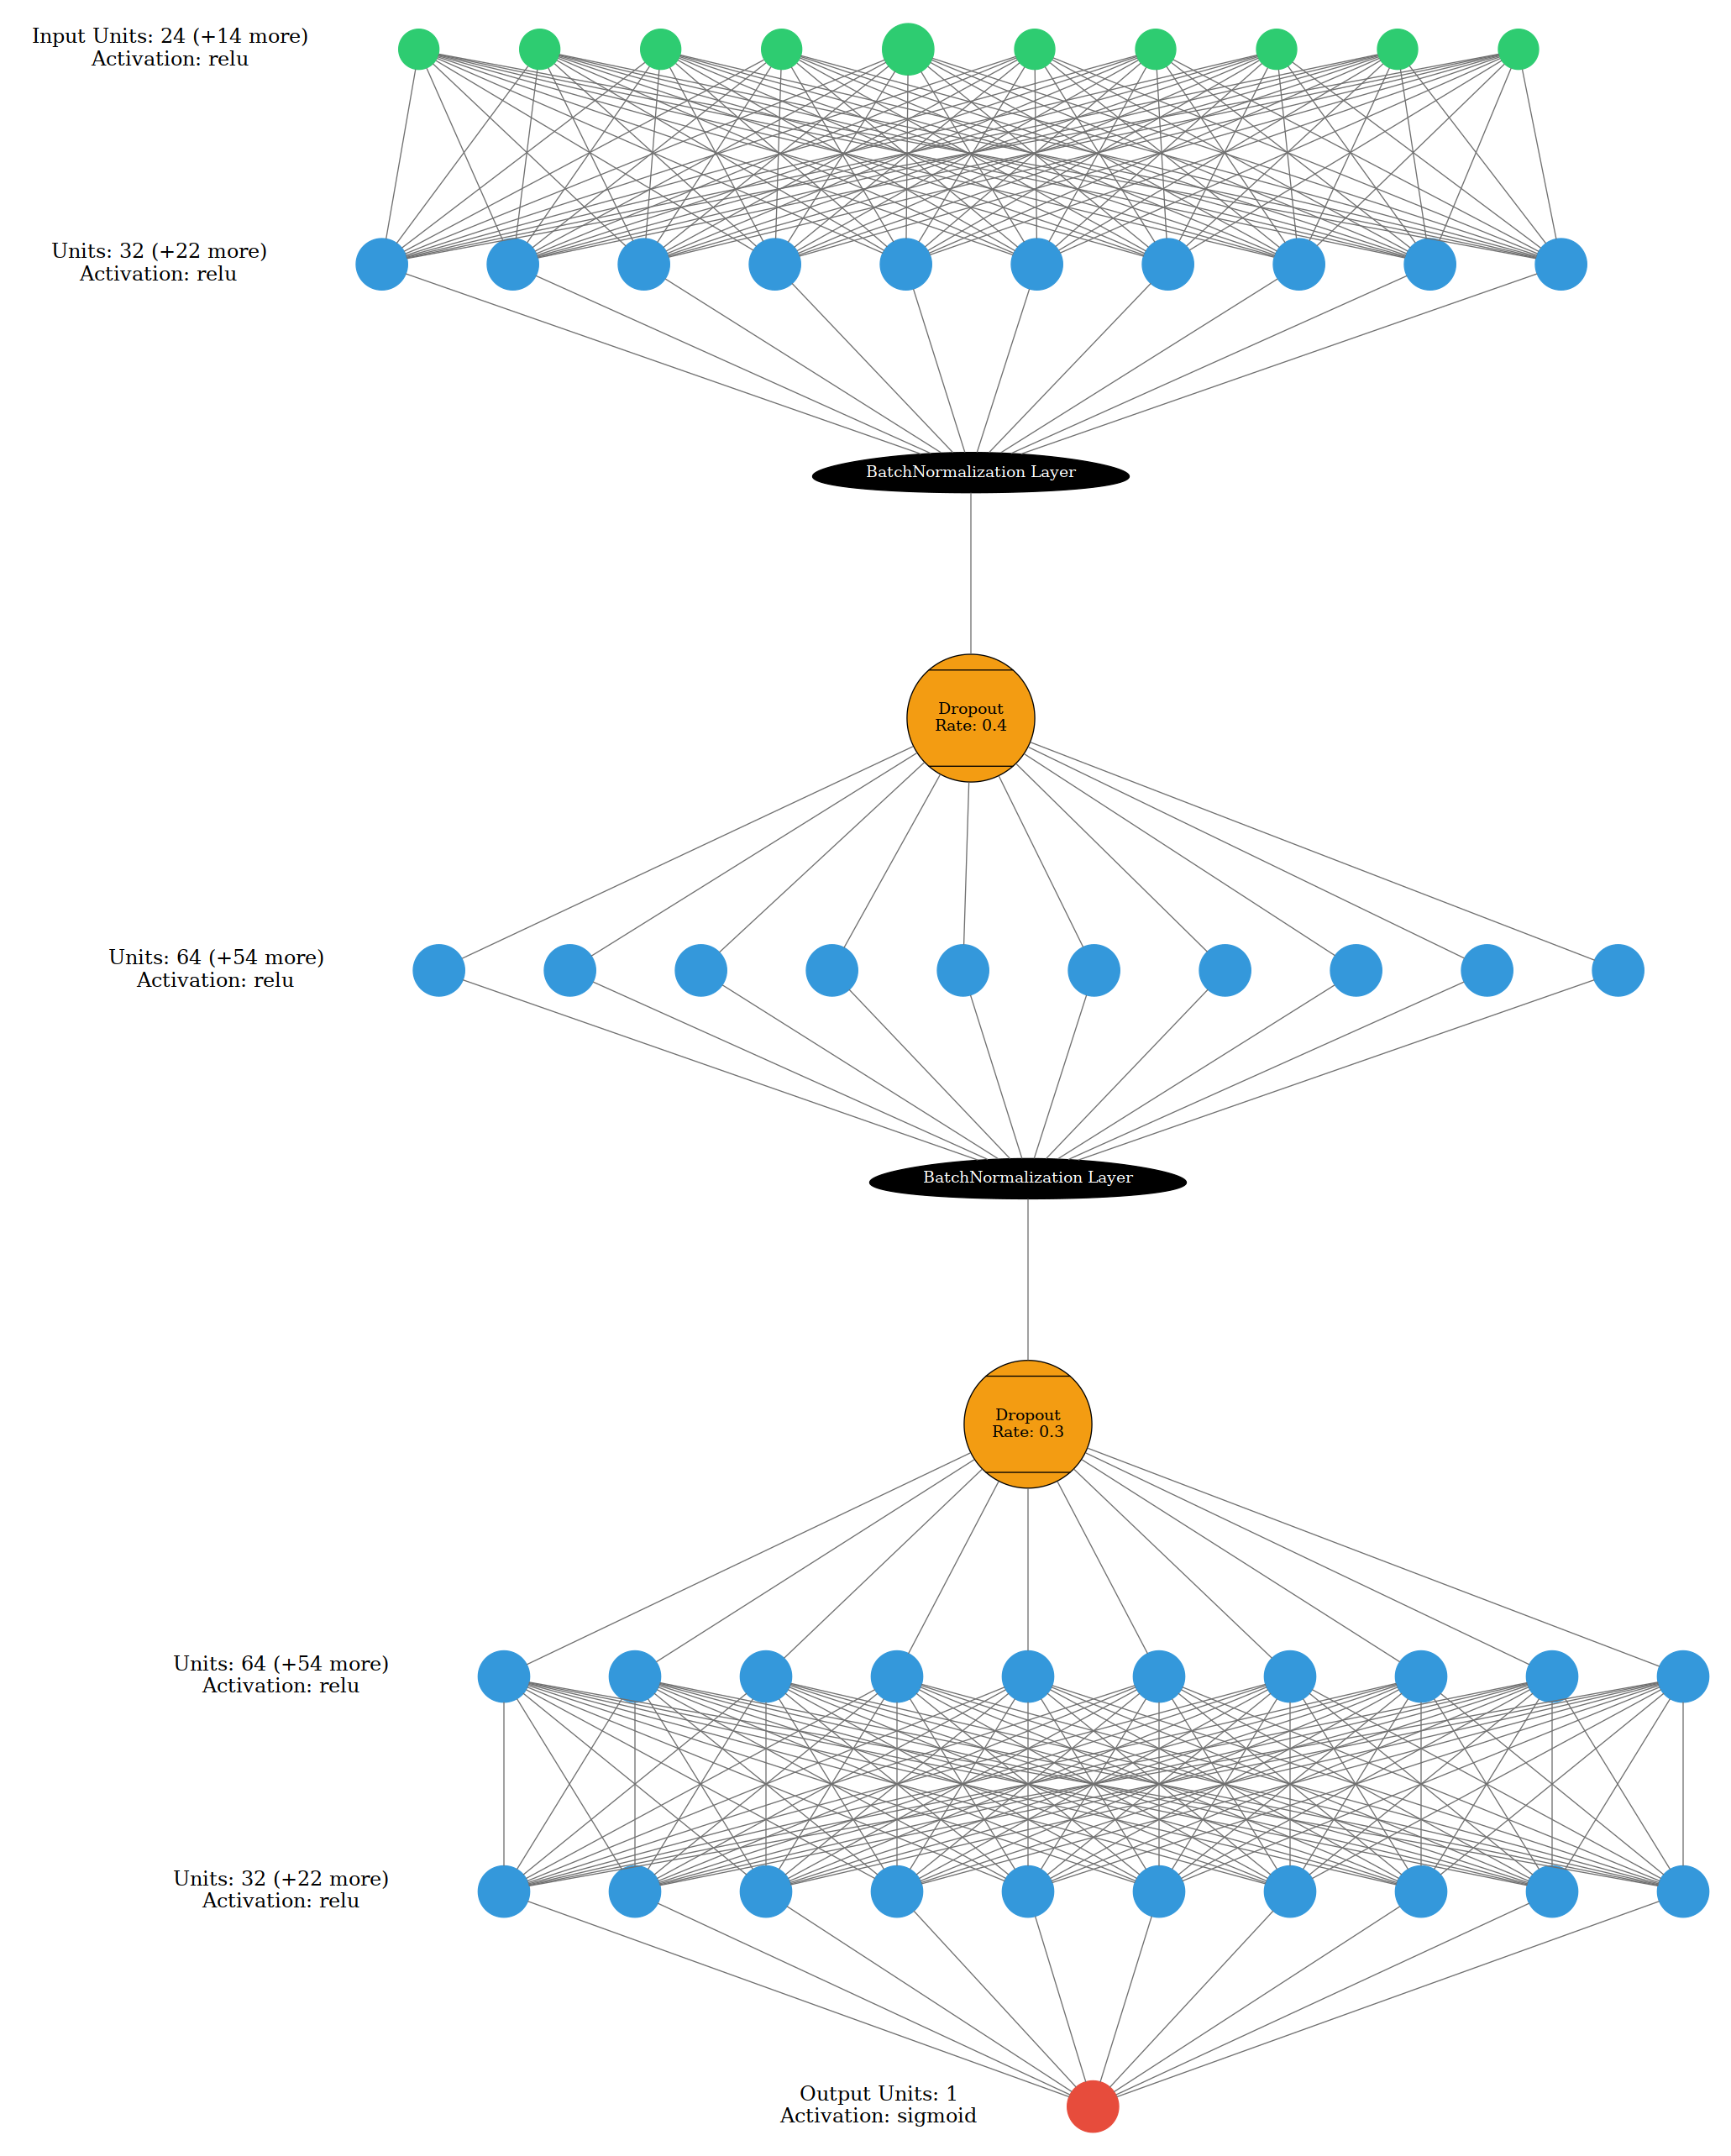

In [23]:
settings = {
    # ALL LAYERS
    'MAX_NEURONS': 10,
}

from keras_visualizer import visualizer
from keras import models, layers

visualizer(model, file_format='png', settings=settings, view=True)

from IPython.display import Image
Image(filename='graph.png')

# Train the model

In [24]:
history = model.fit(
    X_train,
    Y_train,
    batch_size=512,
    epochs=30,
    validation_data=(X_test, Y_test)  # Provide validation data
)

Epoch 1/30
188/188 [==============================] - 2s 5ms/step - loss: 2.4401 - precision_4: 0.5881 - recall_4: 0.5317 - auc_4: 0.6188 - val_loss: 2.3745 - val_precision_4: 0.7239 - val_recall_4: 0.8845 - val_auc_4: 0.8575
Epoch 2/30
188/188 [==============================] - 1s 4ms/step - loss: 2.3436 - precision_4: 0.6895 - recall_4: 0.6869 - auc_4: 0.7567 - val_loss: 2.2539 - val_precision_4: 0.7960 - val_recall_4: 0.9413 - val_auc_4: 0.9279
Epoch 3/30
188/188 [==============================] - 1s 4ms/step - loss: 2.2617 - precision_4: 0.7553 - recall_4: 0.7814 - auc_4: 0.8414 - val_loss: 2.1539 - val_precision_4: 0.8488 - val_recall_4: 0.9532 - val_auc_4: 0.9608
Epoch 4/30
188/188 [==============================] - 1s 4ms/step - loss: 2.1870 - precision_4: 0.8021 - recall_4: 0.8357 - auc_4: 0.8918 - val_loss: 2.0772 - val_precision_4: 0.8929 - val_recall_4: 0.9563 - val_auc_4: 0.9725
Epoch 5/30
188/188 [==============================] - 1s 4ms/step - loss: 2.1194 - precision_4: 

# Save the model

In [25]:
model.save('models/decision_nn_model.keras')

# Display training results

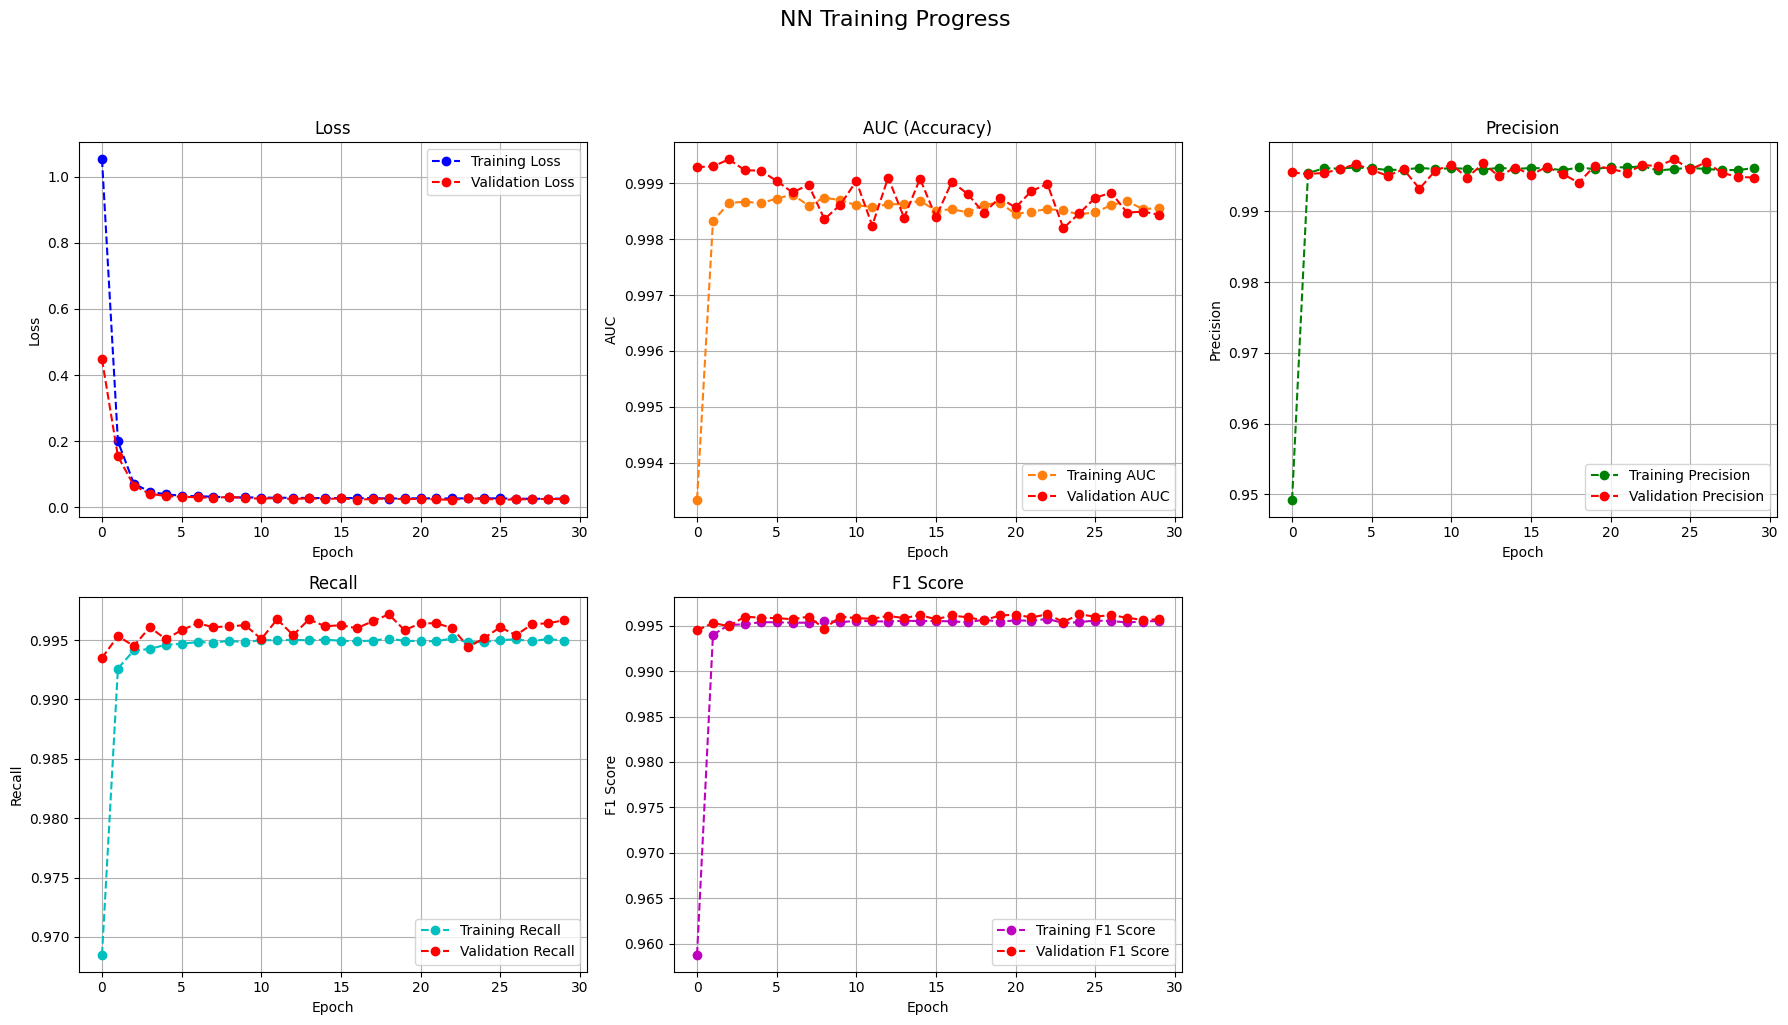

In [18]:
def get_metric(history, metric_name):
    if metric_name in history.history:
        return history.history[metric_name]
    elif f"{metric_name}_1" in history.history:
        return history.history[f"{metric_name}_1"]
    elif f"{metric_name}_2" in history.history:
        return history.history[f"{metric_name}_2"]
    else:
        raise KeyError(f"Metric {metric_name} not found in history.")

epoch_losses = get_metric(history, 'loss')
epoch_val_losses = get_metric(history, 'val_loss')
epoch_accuracies = get_metric(history, 'auc')
epoch_val_accuracies = get_metric(history, 'val_auc')
epoch_precisions = get_metric(history, 'precision')
epoch_val_precisions = get_metric(history, 'val_precision')
epoch_recalls = get_metric(history, 'recall')
epoch_val_recalls = get_metric(history, 'val_recall')

# Calculate F1 score
epoch_f1s = [2 * (p * r) / (p + r) for p, r in zip(epoch_precisions, epoch_recalls)]
epoch_val_f1s = [2 * (p * r) / (p + r) for p, r in zip(epoch_val_precisions, epoch_val_recalls)]

import matplotlib.pyplot as plt

plt.figure(figsize=(18, 10))

# Plot for Loss
plt.subplot(2, 3, 1)
plt.plot(epoch_losses, linestyle='--', marker='o', color='b', label='Training Loss')
plt.plot(epoch_val_losses, linestyle='--', marker='o', color='r', label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss')
plt.legend()
plt.grid(True)

# Plot for AUC (as a proxy for Accuracy)
plt.subplot(2, 3, 2)
plt.plot(epoch_accuracies, linestyle='--', marker='o', color='#ff7f0e', label='Training AUC')
plt.plot(epoch_val_accuracies, linestyle='--', marker='o', color='r', label='Validation AUC')
plt.xlabel('Epoch')
plt.ylabel('AUC')
plt.title('AUC (Accuracy)')
plt.legend()
plt.grid(True)

# Plot for Precision
plt.subplot(2, 3, 3)
plt.plot(epoch_precisions, linestyle='--', marker='o', color='g', label='Training Precision')
plt.plot(epoch_val_precisions, linestyle='--', marker='o', color='r', label='Validation Precision')
plt.xlabel('Epoch')
plt.ylabel('Precision')
plt.title('Precision')
plt.legend()
plt.grid(True)

# Plot for Recall
plt.subplot(2, 3, 4)
plt.plot(epoch_recalls, linestyle='--', marker='o', color='c', label='Training Recall')
plt.plot(epoch_val_recalls, linestyle='--', marker='o', color='r', label='Validation Recall')
plt.xlabel('Epoch')
plt.ylabel('Recall')
plt.title('Recall')
plt.legend()
plt.grid(True)

# Plot for F1 Score
plt.subplot(2, 3, 5)
plt.plot(epoch_f1s, linestyle='--', marker='o', color='m', label='Training F1 Score')
plt.plot(epoch_val_f1s, linestyle='--', marker='o', color='r', label='Validation F1 Score')
plt.xlabel('Epoch')
plt.ylabel('F1 Score')
plt.title('F1 Score')
plt.legend()
plt.grid(True)

plt.suptitle('NN Training Progress', fontsize=16, y=1.02)
plt.tight_layout(rect=[0, 0, 1, 0.96])

# Save the figure
plt.savefig('nn_training_progress.png', dpi=500, bbox_inches='tight', pad_inches=0.5)
plt.show()


# Evaluate the model

750/750 [==============================] - 1s 1ms/step - loss: 0.0151 - precision: 0.9974 - recall: 0.9961 - auc: 0.9989
Loss =  0.015116499736905098
Accuracy =  0.9974132180213928
750/750 [==============================] - 1s 897us/step

=== RESULTS ===
              precision    recall  f1-score   support

      Benign     0.9961    0.9974    0.9968     12000
   Malicious     0.9974    0.9961    0.9967     12000

    accuracy                         0.9968     24000
   macro avg     0.9968    0.9968    0.9967     24000
weighted avg     0.9968    0.9968    0.9967     24000

False Positive Rate = 0.0025833333333333333

Confusion Matrix:
[[11969    31]
 [   47 11953]]


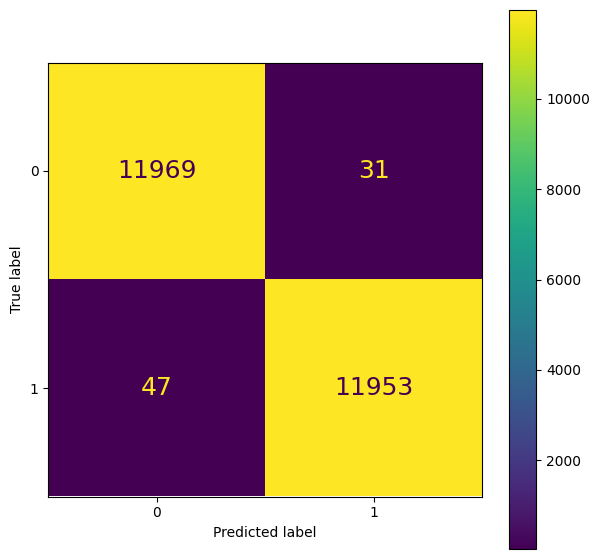

In [10]:
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# Evaluate the model
loss_and_metrics = model.evaluate(X_test, Y_test)
print('Loss = ', loss_and_metrics[0])
print('Accuracy = ', loss_and_metrics[1])

# Generate predictions
Y_pred = model.predict(X_test)
Y_pred = np.round(Y_pred).astype(int)  # Convert probabilities to binary predictions

# Calculate additional metrics
precision = precision_score(Y_test, Y_pred)
recall = recall_score(Y_test, Y_pred)
f1 = f1_score(Y_test, Y_pred)

# Confusion matrix
cm = confusion_matrix(Y_test, Y_pred)

# False Positive Rate
tn, fp, fn, tp = cm.ravel()
fpr = fp / (fp + tn)

# Display the metrics
print('\n=== RESULTS ===')
print(classification_report(Y_test, Y_pred, target_names=['Benign', 'Malicious'], digits=4))
print('False Positive Rate =', fpr)


# Display the confusion matrix
print('\nConfusion Matrix:')
print(cm)

# Optionally, plot the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
fig, ax = plt.subplots(figsize=(7, 7))  # Increase figure size for better readability
disp.plot(ax=ax, values_format='d')
for labels in disp.text_:
    for label in labels:
        label.set_fontsize(18) 
plt.show()

# Feature Importance Analysis

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)
Permutation explainer: 1001it [01:01, 14.12it/s]                                                                                                                                              
No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


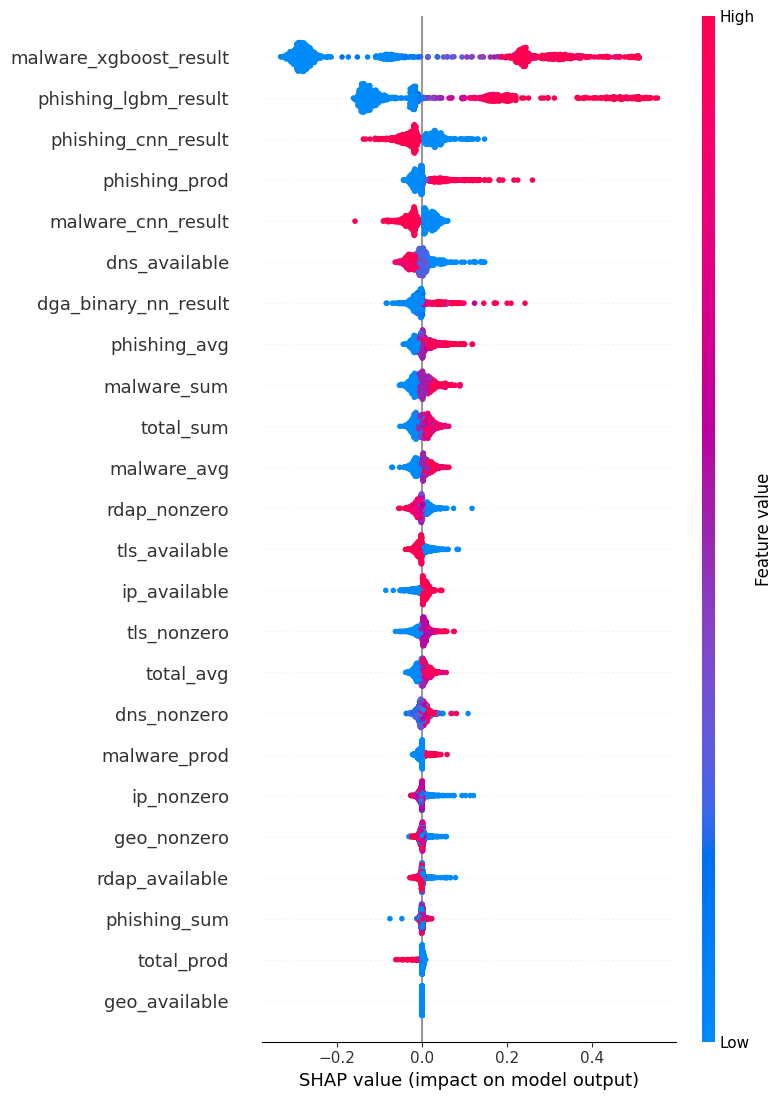

In [11]:
import shap

# Ensure that X_train and X_test are DataFrames with the correct column names
# You can set the column names from the 'features' DataFrame like this:
X_train.columns = features.columns
X_test.columns = features.columns

n_samples = 1000

# Convert your training set to a NumPy format if it's not already
background = X_train[:n_samples].to_numpy()

# Use the generic SHAP Explainer interface
explainer = shap.Explainer(model, background)

# Generate SHAP values for the test set
shap_values = explainer(X_test[:n_samples].to_numpy())

# Plotting the summary plot for feature importance
# Use the column names from the 'features' DataFrame as the feature names
shap.summary_plot(shap_values.values, X_test[:n_samples], feature_names=features.columns, max_display=30)


# Make test predictions

In [12]:
import pandas as pd
import numpy as np
from tensorflow.keras.models import load_model
from sklearn.preprocessing import MinMaxScaler
import joblib
import pyarrow as pa
import pyarrow.parquet as pq
import pandas as pd
from pyarrow import Table

# Load the model and scaler
model = load_model('dga_binary_model.keras')
scaler = joblib.load("dga_binary_scaler.joblib")

# #############################################################
# EDIT this to specify benign / malicious datasets to use     #
# #############################################################
benign_dataset_filenames = [
    '../feature-extraction/floor/lex-benign_2312_anonymized.parquet',
    '../feature-extraction/floor/lex-umbrella_benign_FINISHED.parquet',
]
malicious_dataset_filenames = [
    '../feature-extraction/floor/lex-dga-830k-pick.parquet'
]
# #############################################################
# EDIT this for to set appropriate labels (malware, dga, ...) #
# #############################################################
benign_label = "benign"
malicious_label = "dga"
# #############################################################

def union_tables(tables: [pa.Table]) -> pa.Table:
    union_table = tables[0]
    for table in tables[1:]:
        right_not_in_union = union_table.join(right_table=table, keys='domain_name', join_type='right anti',
                                              coalesce_keys=True, use_threads=True)
        union_table = pa.concat_tables([union_table, right_not_in_union])
    return union_table

# Unify malicious datasets and benign datasets
schema = (pq.read_table(malicious_dataset_filenames[0])).schema # Use the schema from the first malicious filename
benign_tables = [pq.read_table(filename).cast(schema) for filename in benign_dataset_filenames]
malicious_tables = [pq.read_table(filename).cast(schema) for filename in malicious_dataset_filenames]
malicious = union_tables(malicious_tables)
benign = union_tables(benign_tables)

# Convert pyarrow tables to pandas dataframes
df_benign = benign.to_pandas()
df_malicious = malicious.to_pandas()

# Set appropriate labels
df_benign["label"] = benign_label
df_malicious["label"] = malicious_label
class_map = {benign_label: 0, malicious_label: 1}

# Concatentate benign and malicious
test_df = pd.concat([df_benign, df_malicious])

# Handle NaNs
test_df.fillna(-1, inplace=True)


# Take only N random samples
N = 500
test_df = test_df.sample(n=N, random_state=42)

total_predictions = 0
correct_predictions = 0

for index, row in test_df.iterrows():
    domain_name = row['domain_name']
    original_label = row['label']
    
    # Drop "domain_name" and "label" columns
    feature_vector = pd.DataFrame([row])
    feature_vector.drop(columns=['domain_name', 'label'], inplace=True)

     # Scale the feature vector using the loaded scaler
    scaled_feature_vector = scaler.transform(feature_vector)
    
    # Perform prediction
    prediction = model.predict(scaled_feature_vector, verbose=0)
    
    # Extract the predicted class
    predicted_label = "benign" if prediction < 0.5 else "dga"
    
    # Check if the prediction was correct
    if original_label == predicted_label:
        correct_predictions += 1
    
    total_predictions += 1
    
    # Print the result
    result="WRONG"
    if predicted_label == original_label:
        result="OK"
        
    pred_disp = "!!! DGA !!!"
    if predicted_label == "benign":
        pred_disp = "BENIGN"
        
    
    print(f"{result} | {domain_name} ({original_label}), Predicted: {pred_disp}, Prob: {prediction}")

# Calculate accuracy
accuracy = correct_predictions / total_predictions
print(f"Accuracy: {accuracy}")




OSError: No file or directory found at dga_binary_model.keras

OK | support.myhermes.co.uk (benign), Predicted: BENIGN, Prob: [[3.7652226e-35]]
OK | qezuwi1uhcyw61oj46i41fa8za8.com (dga), Predicted: !!! DGA !!!, Prob: [[0.9999933]]
OK | 133.xg4ken.com (benign), Predicted: BENIGN, Prob: [[0.00021088]]
OK | derozepoort.amsterdam (benign), Predicted: BENIGN, Prob: [[1.7357115e-13]]
WRONG | exness.com (benign), Predicted: !!! DGA !!!, Prob: [[0.8341815]]
OK | tivvbkffbdofxavad.to (dga), Predicted: !!! DGA !!!, Prob: [[0.9998361]]
OK | ch24rqgytwmhosodu11y8hz95.org (dga), Predicted: !!! DGA !!!, Prob: [[0.99994075]]
OK | vca.com (benign), Predicted: BENIGN, Prob: [[0.0046461]]
OK | arkadium.com (benign), Predicted: BENIGN, Prob: [[0.08184565]]
OK | enutlpiokwc.com (dga), Predicted: !!! DGA !!!, Prob: [[0.83447474]]
OK | kquas61d8m2y91yufu0lq8rlsl.org (dga), Predicted: !!! DGA !!!, Prob: [[0.9999956]]
OK | swin.bet (benign), Predicted: BENIGN, Prob: [[0.01203865]]
OK | husvhvmqvvfupghv.biz (dga), Predicted: !!! DGA !!!, Prob: [[0.9999895]]
OK | kmsifu.c

OK | tube-2.xvideo.party (benign), Predicted: BENIGN, Prob: [[3.3207368e-17]]
OK | sportmas.bike (benign), Predicted: BENIGN, Prob: [[1.4945806e-05]]
OK | journals.epu.edu.iq (benign), Predicted: BENIGN, Prob: [[4.2451488e-17]]
OK | gurmans.dp.ua (benign), Predicted: BENIGN, Prob: [[3.2404896e-05]]
OK | avedesign.studio (benign), Predicted: BENIGN, Prob: [[3.3500016e-06]]
OK | cyberlab.sutd.edu.sg (benign), Predicted: BENIGN, Prob: [[3.9096804e-17]]
OK | gbo9dbcl547j19nah661alcwtl.com (dga), Predicted: !!! DGA !!!, Prob: [[0.9996364]]
OK | xruzkonkxwntdmpikq.org (dga), Predicted: !!! DGA !!!, Prob: [[0.9999989]]
OK | east.smtp.mx.exch091.serverdata.net (benign), Predicted: BENIGN, Prob: [[0.]]
OK | triagon.mt (benign), Predicted: BENIGN, Prob: [[0.01530445]]
OK | myvwnbtqeswsox.com (dga), Predicted: !!! DGA !!!, Prob: [[0.99982136]]
OK | hypo.com.ro (benign), Predicted: BENIGN, Prob: [[0.17475085]]
OK | qbogvahnlk.biz (dga), Predicted: !!! DGA !!!, Prob: [[0.99622726]]
OK | sqgnkxbvvhb

OK | iagurf.com (dga), Predicted: !!! DGA !!!, Prob: [[0.9104787]]
OK | chavez.salkeiz.k12.or.us (benign), Predicted: BENIGN, Prob: [[9.879189e-33]]
OK | p-lb.cdtx.co (benign), Predicted: BENIGN, Prob: [[6.2895306e-06]]
OK | p178d042a174871f97bf01ad5b8c2261a1.so (dga), Predicted: !!! DGA !!!, Prob: [[0.99965143]]
OK | i0.tagstat.com (benign), Predicted: BENIGN, Prob: [[7.87963e-07]]
OK | ybf3ei17fm4lo1jr967e1046mr9.net (dga), Predicted: !!! DGA !!!, Prob: [[0.999962]]
OK | ioyldrwmhsmtlj.com (dga), Predicted: !!! DGA !!!, Prob: [[0.9999975]]
OK | vekeualav.name (dga), Predicted: !!! DGA !!!, Prob: [[0.9956891]]
OK | ringwoodsc.vic.edu.au (benign), Predicted: BENIGN, Prob: [[4.456764e-15]]
OK | apps.profitihub.com (benign), Predicted: BENIGN, Prob: [[6.527985e-08]]
OK | sxyxeho.ru (dga), Predicted: !!! DGA !!!, Prob: [[0.93510205]]
OK | xcrixa.com (dga), Predicted: !!! DGA !!!, Prob: [[0.9786981]]
OK | fcf71aea67fd6ff05fcf8412236bcffc.info (dga), Predicted: !!! DGA !!!, Prob: [[0.999417